## INTRODUCTION

In [54]:
#utilities
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

#processing
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import metrics

from tqdm import tqdm

from sklearn.svm import SVR, LinearSVC
import statsmodels.api as sm

## LOADING IN THE DATA

In [2]:
df = pd.read_csv('/Users/rishsub/Desktop/Rishabh Subrahmanian - Income Data/usa_00002.csv.gz')
df.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,CITY,STRATA,GQ,RENT,RENTGRS,PERNUM,PERWT,SEX,AGE,EDUC,EDUCD,INCTOT
0,2018,201801,1,2018010000049,75.0,2018000000011,0,160001,4,0,0,1,75.0,2,19,6,65,-1500
1,2018,201801,2,2018010000058,75.0,2018000000021,0,190001,4,0,0,1,75.0,2,18,6,65,1600
2,2018,201801,3,2018010000219,118.0,2018000000031,0,200001,3,0,0,1,118.0,1,53,6,64,10000
3,2018,201801,4,2018010000246,43.0,2018000000041,0,240001,3,0,0,1,43.0,1,28,7,71,0
4,2018,201801,5,2018010000251,16.0,2018000000051,0,270101,3,0,0,1,16.0,2,25,3,30,0


In [3]:
len(df.index)
# I have wayyyy too many observations here for my algorithms to run smoothly.
# I will be sampling this data to try and get a more managable DataFrame to do my work with

3214539

In [4]:
# I'm sampling the data; I'm talking a sample of the sample. This way, I can still make a prediction 
# Without completely ruining my computer and having hours of run time for a single code cell
df_sample = df.sample(n = 50000)
print(len(df_sample.index)) 
# My sampled data will only have 50,000 observations, still a large number but definitely
# less than the 3,214,539 observations in my initial data set
df_sample.head()

50000


,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,CITY,STRATA,GQ,RENT,RENTGRS,PERNUM,PERWT,SEX,AGE,EDUC,EDUCD,INCTOT
1586157,2018,201801,693567,2018000525007,62.0,2018006935671,0,150227,1,0,0,2,88.0,2,33,8,81,65000
1205867,2018,201801,521595,2018000105866,93.0,2018005215951,0,20020,1,0,0,2,92.0,2,56,11,114,500
2037992,2018,201801,893255,2018001027265,98.0,2018008932551,0,330336,1,0,0,1,98.0,2,75,10,101,11400
1512034,2018,201801,660662,2018000645696,46.0,2018006606621,0,130026,1,0,0,1,46.0,1,71,7,71,74500
2338167,2018,201801,1028833,2018000721990,86.0,2018010288331,0,10040,1,0,0,2,102.0,2,51,8,81,38000


In [5]:
df_sample.columns = df_sample.columns.str.lower()
df_prepped = df_sample.set_index(['sample', 'serial'])
df_prepped.columns


Index(['year', 'cbserial', 'hhwt', 'cluster', 'city', 'strata', 'gq', 'rent',
       'rentgrs', 'pernum', 'perwt', 'sex', 'age', 'educ', 'educd', 'inctot'],
      dtype='object')

In [7]:
df_prepped = df_prepped.drop(['year','gq','rentgrs','educd','cbserial','cluster'], axis = 1)
df_prepped.columns


Index(['hhwt', 'city', 'strata', 'rent', 'pernum', 'perwt', 'sex', 'age',
       'educ', 'inctot'],
      dtype='object')

In [24]:
print(df.shape)
print(df_prepped.shape)
# This clearly shows the different sizes of the dataset I originally started with and the one I will be using
# for my tests

(3214539, 18)
(50000, 10)


In [51]:
# The info of the dataset
df_prepped.info

<bound method DataFrame.info of                 hhwt  city  strata  rent  pernum  perwt  sex  age  educ  \
sample serial                                                             
201801 693567   62.0     0  150227     0       2   88.0    2   33     8   
       521595   93.0     0   20020     0       2   92.0    2   56    11   
       893255   98.0     0  330336     0       1   98.0    2   75    10   
       660662   46.0     0  130026     0       1   46.0    1   71     7   
       1028833  86.0     0   10040     0       2  102.0    2   51     8   
...              ...   ...     ...   ...     ...    ...  ...  ...   ...   
       1099429  16.0     0   30042     0       2   19.0    1   45    11   
       1269149  57.0     0  380148   650       5   60.0    2   11     1   
       461249    7.0     0   90017     0       1    8.0    1   70     6   
       715656   71.0     0   10028     0       1   70.0    2   24     8   
       22002    91.0     0  260001     0       2  100.0    2   81   

In [57]:
# This was to see how many unique values of rent there were so I knew
# this that we could predict what rates of rent individuals can have by
# classification
df_prepped['rent'].unique()
df_prepped['rent'].max()

3900

In [9]:

#What we've been doing all year baby
y = df_prepped['rent']
x = df_prepped.drop(columns = 'rent')

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.05, random_state = 490)

x_train_std = x_train.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)
x_test_std  = x_test.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0)

x_train_std = sm.add_constant(x_train_std)
x_test_std  = sm.add_constant(x_test_std)
x_train     = sm.add_constant(x_train)
x_test      = sm.add_constant(x_test)


In [10]:
#RMSE of null model

rmse_null = np.sqrt(np.mean(  (y_test - np.mean(y_train))**2  ))
print(rmse_null)

#Accuracy of null
y_hat_null = y_train.value_counts().index[0]
acc_null = np.mean(y_hat_null == y_test)
acc_null


572.7676413656801


0.7518526315789473

## OLS Summary and RMSE (Inference Model)

In [11]:
#OLS summary
OLS_model = sm.OLS(y_train, x_train).fit()
print(OLS_model.summary2())
# R-Squared (accuracy) is 0.084 for OLS

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.084     
Dependent Variable: rent             AIC:                38860.6839
Date:               2021-05-15 20:04 BIC:                38918.9244
No. Observations:   2500             Log-Likelihood:     -19420.   
Df Model:           9                F-statistic:        26.48     
Df Residuals:       2490             Prob (F-statistic): 4.61e-44  
R-squared:          0.087            Scale:              3.2854e+05
---------------------------------------------------------------------
          Coef.     Std.Err.      t      P>|t|     [0.025     0.975] 
---------------------------------------------------------------------
const    361.0213    70.4161    5.1270   0.0000   222.9411   499.1016
hhwt       0.8211     0.3009    2.7289   0.0064     0.2311     1.4111
city       0.0797     0.0082    9.7271   0.0000     0.0636     0.0957
strata     0.0000     0.0000    1.2589   0.2082    -0.

In [12]:
# As we can see from this correlation matrix, there are quite a few variables that are highly correlated with the one another
# rentgrs(monthly gross rent, utilities and fuels included) is highly corrlelated with rent(basic rent of a unit). Because of this,
# I chose to drop rentgrs from my inference model.
df_prepped.corr()

,hhwt,city,strata,rent,pernum,perwt,sex,age,educ,inctot
hhwt,1.000000,0.046858,0.015377,0.148526,0.055904,0.895855,-0.004743,-0.115742,-0.055226,0.060746
city,0.046858,1.000000,0.040171,0.173897,0.011760,0.051799,0.009573,-0.025966,0.011778,-0.007847
strata,0.015377,0.040171,1.000000,0.025971,0.017569,0.017437,-0.006066,-0.014676,0.009986,0.006828
rent,0.148526,0.173897,0.025971,1.000000,0.037667,0.147691,0.006784,-0.157929,-0.020407,0.041860
pernum,0.055904,0.011760,0.017569,0.037667,1.000000,0.105487,-0.002227,-0.547436,-0.502229,0.561374
perwt,0.895855,0.051799,0.017437,0.147691,0.105487,1.000000,-0.009029,-0.135786,-0.061926,0.056635
sex,-0.004743,0.009573,-0.006066,0.006784,-0.002227,-0.009029,1.000000,0.044132,0.033188,-0.021597
age,-0.115742,-0.025966,-0.014676,-0.157929,-0.547436,-0.135786,0.044132,1.000000,0.500984,-0.644088
educ,-0.055226,0.011778,0.009986,-0.020407,-0.502229,-0.061926,0.033188,0.500984,1.000000,-0.706249
inctot,0.060746,-0.007847,0.006828,0.041860,0.561374,0.056635,-0.021597,-0.644088,-0.706249,1.000000


In [43]:
#OLS RMSE
rmse_std_final = np.sqrt(np.mean(  (y_test - OLS_model.predict(x_test))**2  ))
rmse_test = np.sqrt(np.mean(  (y_test - OLS_model.predict(x_test))**2  ))
print(rmse_test)


551.7365439496874


In [52]:
#OLS RMSE
df_prepped.replace([np.inf, -np.inf], np.nan)
df_prepped.dropna()

fit_lasso_tuned = sm.OLS(y_train, x_train_std).fit_regularized(alpha = 10, L1_wt = 1)
fit_lasso_tuned.params
beta = fit_lasso_tuned.params
beta.index[beta == 0]
x_train_std_trim = x_train_std.loc[:, ~x_train_std.columns.isin(beta.index[beta == 0])]
x_test_trim = x_test.loc[:, ~x_test_std.columns.isin(beta.index[beta == 0])]

fit_final = sm.OLS(y_train, x_train_std_trim).fit()
fit_final.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.085     
Dependent Variable: rent             AIC:                38857.2856
Date:               2021-05-15 21:52 BIC:                38903.8779
No. Observations:   2500             Log-Likelihood:     -19421.   
Df Model:           7                F-statistic:        33.97     
Df Residuals:       2492             Prob (F-statistic): 1.80e-45  
R-squared:          0.087            Scale:              3.2835e+05
--------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|     [0.025     0.975] 
--------------------------------------------------------------------
const      278.4256   11.4604  24.2946  0.0000   255.9527   300.8985
hhwt        60.1817   11.5622   5.2050  0.0000    37.5092    82.8542
city       112.6590   11.4938   9.8017  0.0000    90.1206   135.1973
strata      14.8642   11.5007   1.2925  0.1963    -7.6876    37.4161
pernum     -37.5160   14.6554  -2.5599  0.0105   -66.2539    -8.7780
sex         15.3646   11.4963   1.3365  0.1815    -7.1787    37.9080
age       -134.9985   14.4470  -9.3444  0.0000  -163.3278  -106.6692
educ        37.9859   14.0562   2.7024  0.0069    10.4228    65.5490
-------------------------------------------------------------------
Omnibus:              1229.192      Durbin-Watson:         1.999   
Prob(Omnibus):        0.000         Jarque-Bera (JB):      6981.361
Skew:                 2.329         Prob(JB):              0.000   
Kurtosis:             9.732         Condition No.:         2       
===================================================================

"""

Interpretation:
It looks like the 3 most significant marginal effects in this rergression are the city, age, and education. That is because thses are the variables that have the lowest p-value.

# Prediction

## KNN Model

In [14]:
kf = KFold(n_splits = 5, random_state = 490, shuffle = True)

k_nbrs = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
accuracy = {}


for k in tqdm(k_nbrs):
    acc = []
    for trn, tst in kf.split(x_train_std):
        yhat = KNeighborsClassifier(n_neighbors = k
                                   ).fit(x_train_std.iloc[trn], y_train.iloc[trn]
                                        ).predict(x_train_std.iloc[tst])        
        acc.append(np.mean(yhat == y_train.iloc[tst]))
    accuracy[k] = np.mean(acc)

100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


In [15]:
print('corner-solution value of k is = %s' % max(accuracy, key = accuracy.get))

corner-solution value of k is = 20


In [40]:
x_test_knn = x_test.sample(frac = 0.1, random_state = 490)
y_test_knn = y_test.sample(frac = 0.1, random_state = 490)

In [41]:
%%time
best_k = max(accuracy, key = accuracy.get)
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(x_train_std, y_train)
acc_knn = knn.score(x_test_knn, y_test_knn)

print(acc_knn)

0.7482105263157894
CPU times: user 283 ms, sys: 3.71 ms, total: 287 ms
Wall time: 298 ms


## Random Forest

In [35]:
clf_rf = RandomForestClassifier(n_estimators = 500,
                          random_state = 490,
                          max_features = 'sqrt',
                          oob_score = True,
                          n_jobs = -1,
                          verbose = 1)

clf_rf.fit(x_train_std, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


RandomForestClassifier(max_features='sqrt', n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=490, verbose=1)

In [36]:
acc_rf = clf_rf.score(x_test, y_test)
acc_rf

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    7.1s finished


0.7518526315789473

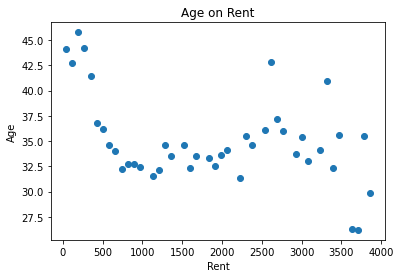

In [62]:
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
bin_mean, bin_edge, _ = binned_statistic(df_prepped.rent, df_prepped.age, bins = 50)

x = np.average([bin_edge[:-1], bin_edge[1:]], axis = 0)
plt.scatter(x, bin_mean, label = '%d bins' % 50)
plt.xlabel('Rent')
plt.ylabel('Age')
plt.title('Age on Rent')

plt.show()

## Comparison

This is the comparison between all three models we used:

|              |Performance (Accuracy)  | Ease
|--------------|------------------------|----------------
|Null model    | 0.7510371460204014     |Basic level formulaic work|
|KNN Model     | 0.7482105263157894    |Difficult to always implement becauses of the amount of time it takes, also a lazy algorithm because it |
|Random Forest | 0.7504631578947368 | Good test to see if the model predicts the value of the rent efficiently, easy to use because after you find the  |

Random Forest model had the best accuracy of the two models I tested. However, when looking at the three models as a whole, the null model had the best accuracy. This can be due to many different reasons which will be further discussed in the write up.

## Confusion matrix for descrete variables

ValueError: The number of FixedLocator locations (131), usually from a call to set_ticks, does not match the number of ticklabels (93).

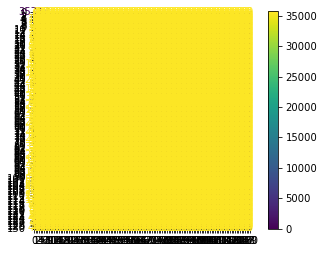

In [55]:
sk_fig = plot_confusion_matrix(knn, x_test, y_test)
plt.title('KNN')

plt.show()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    6.6s finished


ValueError: The number of FixedLocator locations (131), usually from a call to set_ticks, does not match the number of ticklabels (93).

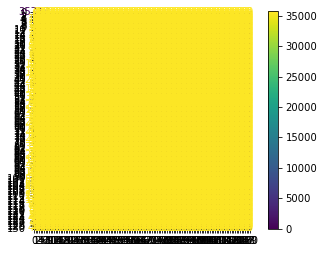

In [56]:
sk_fig = plot_confusion_matrix(clf_rf, x_test, y_test)
plt.title('Random Forest')

plt.show()